#Importing essential Libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
import numpy as np
#Importing some essential Libraries:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import torchvision.transforms.functional as F
import torch.nn.functional as F1
import torchvision

#Loading Data

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio

image_path = '/content/drive/MyDrive/DL/Datasets/train'

image_data = []
image_masks = []

#Loading images
print("Loading Training Images...")

filenames = [os.path.join(image_path, img) for img in os.listdir(image_path)]
filenames.sort()
count=0
for img in filenames:
  count += 1
  image_arr = cv2.imread(img)  #One image of dim (W, H, 3)

  #Resizing
  new_image = cv2.resize(image_arr, (240,240))  
  new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB) 
  image_data.append(new_image)
  if count%1000 ==0:
    print(count)
  
images = np.array(image_data)



#Loading Masks
image_mask_path = '/content/drive/MyDrive/DL/Datasets/train_masks'
print("Loading Training Masks...")
filenames = [os.path.join(image_mask_path, img) for img in os.listdir(image_mask_path)]
filenames.sort()
count = 0
for img in filenames:
  count += 1
  image_arr = imageio.imread(img)  #One image of dim (W, H, 3)
  
  #Resizing
  new_image = cv2.resize(image_arr, (240,240))  
  image_masks.append(new_image)
  if count%1000 ==0:
    print(count) 
  
images = np.array(image_data)
masks = np.array(image_masks)

print("Training images shape: " ,images.shape)     
print("Training Masks shape: ",masks.shape)      #Labels are grayscale Images

Loading Training Images...
1000
2000
3000
4000
5000
Loading Training Masks...
1000
2000
3000
4000
5000
Training images shape:  (5088, 240, 240, 3)
Training Masks shape:  (5088, 240, 240)


In [ ]:
masks[masks<100] = 0
masks[masks>=100] = 1.0


In [ ]:
path_save = '/content/drive/MyDrive/DL/Datasets/carvana1_240'
path_save_mask = '/content/drive/MyDrive/DL/Datasets/carvana1_mask_240'
np.save(path_save, images)
np.save(path_save_mask, masks)

In [ ]:
#For faster Loading above loaded images are saved as numpy array.
path_save = '/content/drive/MyDrive/DL/Datasets/carvana1_240.npy'
path_save_mask = '/content/drive/MyDrive/DL/Datasets/carvana1_mask_240.npy' 
images = np.load(path_save)
masks = np.load(path_save_mask)

Visualizing some images:

Image


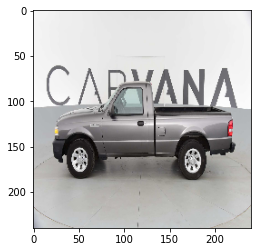

It's Mask


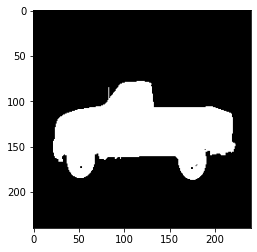

In [ ]:
plt.figure(1)
print("Image")
plt.imshow(images[100], cmap= 'gray')
plt.show()
plt.figure(2)
print("It's Mask")
plt.imshow(masks[100], cmap= 'gray')
plt.show()

Checking if GPU is available

In [ ]:
#Converting the images into tensor
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'

cuda GPU is available


In [ ]:
#validation dataset
val = images[5050:5080,:,:,:]
val_mask = masks[5050:5080,:,:]

In [ ]:
print("Val shape: ", val.shape)
print("Val mask shape: ", val_mask.shape)

Val shape:  (30, 240, 240, 3)
Val mask shape:  (30, 240, 240)


In [ ]:
#Train Dataset
images = images[0:5050]
masks = masks[0:5050]

In [ ]:
print("training images shape: ", images.shape)
print("training masks shape: ", masks.shape)

training images shape:  (5050, 240, 240, 3)
training masks shape:  (5050, 240, 240)


Transferring the Images to GPU

In [ ]:
images = torch.tensor(images, device = DEVICE)
masks = torch.tensor(masks, device = DEVICE)

Normalize the image

In [ ]:
images = images.float()
mean = (torch.mean(images))
images = images/ mean

In [ ]:
val = torch.tensor(val, device = DEVICE)
val_mask = torch.tensor(val_mask, device = DEVICE)
val = val.float()
val = val/ mean

Reshaping the Image for network to work on

In [ ]:
#changing image dimension to that which is accepted by the the model
images = images.permute(0,3,1,2)

In [ ]:
val = val.permute(0,3,1,2)

In [ ]:
import torchvision.transforms.functional as TF

#Creating Unet Netowk architecture

##Paper: https://arxiv.org/pdf/1804.03999v3.pdf


In [ ]:
class unet(nn.Module):

  def __init__(self, in_channels, out_channels):    
    super(unet, self).__init__()
    self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, 3, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )

    #upsampling layers

    #adding attention part
    self.sig = nn.Sigmoid()
    self.relu = nn.ReLU()
    #self.attn1_conv1 =  nn.Sequential( nn.Conv2d(512, 1024, 1, 2, 0, bias=False), nn.BatchNorm2d(1024))
    self.attn1_conv1 = nn.Conv2d(512, 1024, 1, 2, 0, bias=False)
    #self.attn1_conv2 = nn.Sequential(nn.Conv2d(1024, 1024, 1, 1, 0, bias=False) , nn.BatchNorm2d(1024)) #add after this
    self.attn1_conv2 = nn.Conv2d(1024, 1024, 1, 1, 0, bias=False)
    self.attn1_conv3 =  nn.Conv2d(1024, 1, 1, 1, 0, bias=False)  #take sigmoid after this
    #upsample to match size inside attention layer
    self.attn1_up1 = nn.ConvTranspose2d( 1, 1, kernel_size=2, stride=2, )#multiply and concatenate after this

    self.up1 = nn.ConvTranspose2d( 1024, 512, kernel_size=2, stride=2, )
    self.conv6 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
    
    #adding attention part
    #self.attn2_conv1 = nn.Sequential( nn.Conv2d(256, 512, 1, 2, 0, bias=False) , nn.BatchNorm2d(512))
    self.attn2_conv1 = nn.Conv2d(256, 512, 1, 2, 0, bias=False)
    #self.attn2_conv2 = nn.Sequential( nn.Conv2d(512, 512, 1, 1, 0, bias=False) , nn.BatchNorm2d(512)) #add after this
    self.attn2_conv2 = nn.Conv2d(512, 512, 1, 1, 0, bias=False)
    self.attn2_conv3 =  nn.Conv2d(512, 1, 1, 1, 0, bias=False) #take sigmoid after this
    #upsample to match size inside attention layer
    self.attn2_up1 = nn.ConvTranspose2d( 1, 1, kernel_size=2, stride=2, )#multiply and concatenate after this
    
    self.up2 = nn.ConvTranspose2d( 512, 256, kernel_size=2, stride=2, )
    self.conv7 = nn.Sequential(
            nn.Conv2d(512, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    
    #adding attention part
    #self.attn3_conv1 = nn.Sequential( nn.Conv2d(128, 256, 1, 2, 0, bias=False), nn.BatchNorm2d(256))
    self.attn3_conv1 = nn.Conv2d(128, 256, 1, 2, 0, bias=False)
    #self.attn3_conv2 = nn.Sequential( nn.Conv2d(256, 256, 1, 1, 0, bias=False) , nn.BatchNorm2d(256)) #add after this
    self.attn3_conv2 = nn.Conv2d(256, 256, 1, 1, 0, bias=False)
    self.attn3_conv3 =  nn.Conv2d(256, 1, 1, 1, 0, bias=False) #take sigmoid after this
    #upsample to match size inside attention layer
    self.attn3_up1 = nn.ConvTranspose2d( 1, 1, kernel_size=2, stride=2, )#multiply and concatenate after this

    self.up3 = nn.ConvTranspose2d( 256, 128, kernel_size=2, stride=2, )
    self.conv8 = nn.Sequential(
            nn.Conv2d(256, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    
    #adding attention part
    #self.attn4_conv1 =  nn.Sequential(nn.Conv2d(64, 128, 1, 2, 0, bias=False), nn.BatchNorm2d(128))
    self.attn4_conv1 = nn.Conv2d(64, 128, 1, 2, 0, bias=False)
    #self.attn4_conv2 = nn.Sequential(nn.Conv2d(128, 128, 1, 1, 0, bias=False), nn.BatchNorm2d(128)) #add after this
    self.attn4_conv2 = nn.Conv2d(128, 128, 1, 1, 0, bias=False)
    self.attn4_conv3 =  nn.Conv2d(128, 1, 1, 1, 0, bias=False) #take sigmoid after this
    #upsample to match size inside attention layer
    self.attn4_up1 = nn.ConvTranspose2d( 1, 1, kernel_size=2, stride=2, )#multiply and concatenate after this

    self.up4 = nn.ConvTranspose2d( 128, 64, kernel_size=2, stride=2, )
    self.conv9 = nn.Sequential(
            nn.Conv2d(128, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.conv_final = nn.Conv2d(64, out_channels, 3, 1, 1)               #output channel is the no of classes
    
  def forward(self, input):

    #Downsampling Part
    out = self.conv1(input)
    out_1 = out
    out = self.pool1(out)       #()

    out = self.conv2(out)
    out_2 = out
    out = self.pool2(out)

    out = self.conv3(out)
    out_3 = out
    out = self.pool3(out)
    
    out = self.conv4(out)
    out_4 = out
    out = self.pool4(out)
    
    out = self.conv5(out)
    gate = out
    
    #Upsampling part
    #adding attention layer:    
    out = self.up1(out) 
    atn1 = self.attn1_conv1(out_4)
    atn2 = self.attn1_conv2(gate)
    atn = atn1 + atn2
    atn = self.relu(atn)
    atn = self.attn1_conv3(atn)
    atn = self.sig(atn)
    atn = self.attn1_up1(atn)
    atn = out_4*atn

    #print(atn.shape)

    """if out_4.shape != out.shape:
      out = TF.resize(out, size= [out_4.shape[2], out_4.shape[3]])"""
    
    out = torch.cat((atn, out), dim = 1)
    out = self.conv6(out)
    gate = out


    out = self.up2(out)  

    #adding attention layer:    
    atn1 = self.attn2_conv1(out_3)
    atn2 = self.attn2_conv2(gate)
    atn = atn1 + atn2
    atn = self.relu(atn)
    atn = self.attn2_conv3(atn)
    atn = self.sig(atn)
    atn = self.attn2_up1(atn)
    atn = out_3*atn

    #print(atn.shape)
    """if out_3.shape != out.shape:
      out = TF.resize(out, size= [out_3.shape[2], out_3.shape[3]]) """
    out = torch.cat((atn, out), dim = 1)
    out = self.conv7(out)
    gate = out

    out = self.up3(out)

    #adding attention layer:    
    atn1 = self.attn3_conv1(out_2)
    atn2 = self.attn3_conv2(gate)
    atn = atn1 + atn2
    atn = self.relu(atn)
    atn = self.attn3_conv3(atn)
    atn = self.sig(atn)
    atn = self.attn3_up1(atn)
    atn = out_2*atn

    #print(atn.shape)
    """if out_2.shape != out.shape:
      out = TF.resize(out, size= [out_2.shape[2], out_2.shape[3]])"""    
    out = torch.cat((atn, out), dim = 1)
    out = self.conv8(out)
    gate = out

    out = self.up4(out) 

    #adding attention layer:    
    atn1 = self.attn4_conv1(out_1)
    atn2 = self.attn4_conv2(gate)
    atn = atn1 + atn2
    atn = self.relu(atn)
    atn = self.attn4_conv3(atn)
    atn = self.sig(atn)
    atn = self.attn4_up1(atn)
    atn = out_1*atn

    #print(atn.shape)


    """if out_1.shape != out.shape:
      out = TF.resize(out, size= [out_1.shape[2], out_1.shape[3]])"""    
    out = torch.cat((atn, out), dim = 1)
    out = self.conv9(out)

    out = self.conv_final(out)

    return out





In [ ]:
model = unet(3,2).to(device = DEVICE)

In [ ]:
model(images[0].reshape(1, images[0].shape[0], images[0].shape[1], images[0].shape[2])).shape

torch.Size([1, 2, 240, 240])

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)        #update the weights of the model 
loss_type = torch.nn.CrossEntropyLoss()
step_lr = lr_scheduler.StepLR(optimizer, step_size= 100, gamma = 0.9)   #Every 100 epochs our learning rate will be multiplied by gamma

In [ ]:
np.unique(masks[70].cpu().numpy())

array([0, 1], dtype=uint8)

#Training the model using pytorch dataloader and other pytorch tools

In [ ]:
from torch.utils.data import Dataset, DataLoader     #Importing Dataloader

In [ ]:
class CustomImageDataset(Dataset):    #Making the class that takes the index and gives the images and it's corrosponding masks
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return images.shape[0]

    def __getitem__(self, idx):
        x_batch = self.images[idx]
        y_batch = self.masks[idx]
        return x_batch, y_batch

In [ ]:
data = CustomImageDataset(images, masks)  #data is the object for the class that takes index and gives data and it's mask

In [ ]:
batchsize = 25
dataloader = DataLoader(dataset= data, batch_size= batchsize, shuffle= True)

In [ ]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchmetrics import JaccardIndex
jaccard = JaccardIndex(num_classes=2).to(DEVICE)

##Training Network

In [ ]:
#Model Training
loss_graph = []
num_epochs = 22   #Here each epoch means that at each epoch the model will train once over the entire datset using sgd on small batches


for j in range(num_epochs):

  with torch.no_grad():
    model.eval()
    pred = model(val)
    pred = pred.argmax(axis= 1)
    print("Jaccard index before epoch ", j, " is: ", jaccard(pred, val_mask).cpu().item()*100)

  model.train()
  for i, (x_batch, y_batch) in enumerate(dataloader):

    optimizer.zero_grad()
    y_pred = model(x_batch)
    y_pred = y_pred.permute(0,2,3,1)
    y_pred = y_pred.reshape(-1,2)
    y_batch = y_batch.reshape(-1)
  
    loss = loss_type(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    loss_graph.append(loss.cpu().item())

    #schedular step
    #step_lr.step()

  print("Epoch: ", j+1, ", loss is: ", loss.cpu().item())
  #print("Learning rate is: ", optimizer.state_dict()['param_groups'][0]['lr'])


with torch.no_grad():
    model.eval()
    pred = model(val)
    pred = pred.argmax(axis= 1)
    print("Final Jaccard Index is: ", jaccard(pred, val_mask).cpu().item()*100)

Jaccard index before epoch  0  is:  37.890857458114624
Epoch:  1 , loss is:  0.019976191222667694
Jaccard index before epoch  1  is:  98.0361819267273
Epoch:  2 , loss is:  0.01247346494346857
Jaccard index before epoch  2  is:  98.64015579223633
Epoch:  3 , loss is:  0.01076437532901764
Jaccard index before epoch  3  is:  98.87028932571411
Epoch:  4 , loss is:  0.008303285576403141
Jaccard index before epoch  4  is:  99.05200004577637
Epoch:  5 , loss is:  0.007771403528749943
Jaccard index before epoch  5  is:  99.10428524017334
Epoch:  6 , loss is:  0.006882294546812773
Jaccard index before epoch  6  is:  99.14138317108154
Epoch:  7 , loss is:  0.007241023704409599
Jaccard index before epoch  7  is:  99.15374517440796
Epoch:  8 , loss is:  0.006438637152314186
Jaccard index before epoch  8  is:  99.15889501571655
Epoch:  9 , loss is:  0.008828429505228996
Jaccard index before epoch  9  is:  99.07495379447937
Epoch:  10 , loss is:  0.008459817618131638
Jaccard index before epoch  10 

In [ ]:
with torch.no_grad():
    model.eval()
    pred = model(val)
    pred = pred.argmax(axis= 1)
    print("Final Jaccard Index is: ", jaccard(pred, val_mask).cpu().item()*100)

Final Jaccard Index is:  99.34025406837463


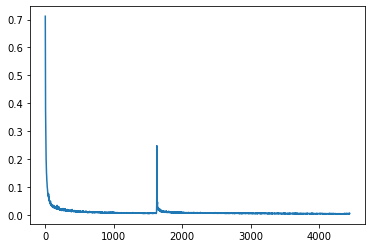

In [ ]:
#Loss Graph
plt.plot(loss_graph)  
plt.show()

#Final result from the Trained Model: 

Prediction on seen data (Training data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image


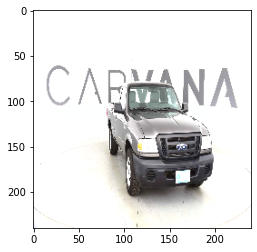

Predicted segmentation mask


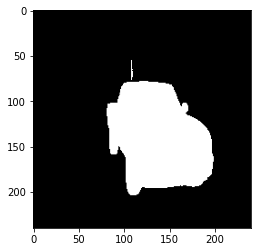

Actual mask


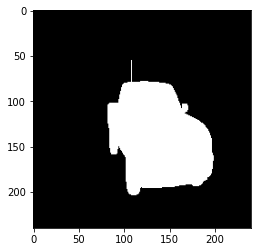

In [ ]:
model.eval()
y = model(images[111].reshape(1,images.shape[1], images.shape[2], images.shape[3]))
y = y.argmax(axis= 1)
y = y.reshape(240,240)
plt.figure(3)
print("Image")
plt.imshow(np.array(images[111].permute(1,2,0).detach().cpu().numpy()), cmap= 'gray')
plt.show()
plt.figure(3)
print("Predicted segmentation mask")
plt.imshow(np.array(y.detach().cpu().numpy()), cmap= 'gray')
plt.show()

plt.figure(4)
print("Actual mask")
plt.imshow(np.array(masks[111].clone().cpu()), cmap= 'gray')
plt.show()

Prediction on unseen data (Validation data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image


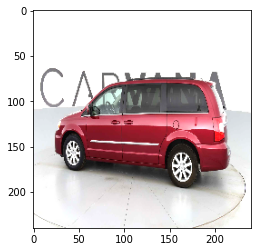

Predicted segmentation mask


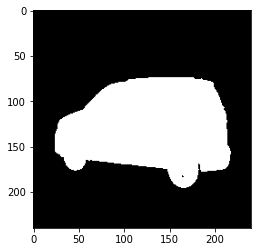

Actual mask


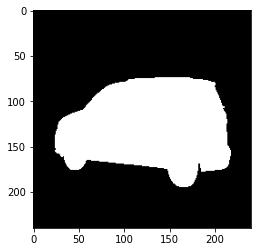

In [ ]:
model.eval()
y = model(val[11].reshape(1,val.shape[1], val.shape[2], val.shape[3]))
y = y.argmax(axis= 1)
y = y.reshape(240,240)
plt.figure(3)
print("Image")
plt.imshow(np.array(val[11].permute(1,2,0).detach().cpu().numpy()), cmap= 'gray')
plt.show()
plt.figure(3)
print("Predicted segmentation mask")
plt.imshow(np.array(y.detach().cpu().numpy()), cmap= 'gray')
plt.show()

plt.figure(4)
print("Actual mask")
plt.imshow(np.array(val_mask[11].clone().cpu()), cmap= 'gray')
plt.show()